# Naive Bayes like & KNN classifier

## Explanation

We compute the overall proportion of tweets classified in each class,$0.63, 0.21, 0.16$, which is unbalanced.

Next we compute a dictionary with words as keys and proportion of appearance in each class of tweets as values.
This should give us a 3D vector with 1-norm being 1. We substract to each proportion, the overall proportion. We interpret this a direction, so for a new unclassified sentence, we sum the directions of each word (the ones appearing on the training set), and pick the class corresponding to the largest resulting component.
In a variant algorithm, since for words that appear only in one class, the proportion was the same, $100%$, we multiply the direction due to such word by the number of appearances in the dataset, to give it a more sensible weight.
This already gives a 76% accuracy.

To improve it to 78%, we can train a KNN(30) or SVM on the resulting points instead of picking the largest component.

For future improvements, we should add bigrams to our dictionary, as we could do with any other feature.
Notice that the airline company is included and taken into account with due weight, as it is the first word of the text.

## Code

In [4]:
class tweet_clf:
    def __init__(self,mincount=1,purecasesspecial=True,maxcomp=False):
        import numpy as np
        import pandas as pd
        from sklearn.neighbors import KNeighborsClassifier
        
        self.X_train = []
        self.y_train = []
        self.classes = []
        self.type_counts = {}
        self.class_ratio = []
        
        self.min_count = int(max(1,mincount))
        self.pure_cases_special = purecasesspecial
        self.clf = KNeighborsClassifier(n_neighbors=30)
        self.max_comp = maxcomp

    def tweet_to_words(self,inputtweet):
        import re
        letters_only = re.sub("[^a-zA-Z]", " ",inputtweet) #now our tweet doesn't conatin symobols and are just english letters
        #letters_only = inputtweet.replace("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|([0-9])","")
        words = letters_only.lower().split()
        meaningful_words = [word for word in words
                            if 'http' not in word and not word.startswith('@') and word != 'RT'
                           ] 
        return( " ".join( meaningful_words ))
    
    def sentiment_to_number(self,sentiment):
        #assert(sentiment in self.classes)
        return float(self.classes.index(sentiment))
    def number_to_sentiment(self,number):
        return self.classes[int(number)]
    def fit(self,X,y):
        assert len(X) == len(y)
        self.classes = list(np.unique(y))
        self.y_train = [self.sentiment_to_number(x) for x in y]
        self.X_train = [self.tweet_to_words(x) for x in X]
        
        #make a dict{word:(neg_count,neu_count,pos_count)}
        N_tweets = len(self.y_train)
        self.type_counts = {}
        for i in range(N_tweets):
            xi = self.X_train[i]
            yi = self.y_train[i]
            words = xi.lower().split()
            for word in words:
                try:
                    self.type_counts[word][int(yi)] += 1
                except KeyError:
                    self.type_counts[word] = np.zeros(3)
                    self.type_counts[word][int(yi)] = 1
        
        self.class_ratio = [sum(1 for class_j in self.y_train if self.number_to_sentiment(class_j)==class_i)/N_tweets for class_i in self.classes]
        
        if not self.max_comp:
            X_clf_train = self.tweets_directions(self.X_train)
            X_clf_train = np.array(X_clf_train)
            self.clf.fit(X_clf_train,self.y_train)
    
    def word_direction(self,word):
        direction = np.zeros(3)
        try:
            xi=self.type_counts[word]
            row_sum=sum(xi)#sum along cols of x: negative, neutral, positive
            if row_sum >= self.min_count:
                for j in range(len(xi)):
                    direction[j]= xi[j]/row_sum - self.class_ratio[j]
                    if xi[j] == row_sum and self.pure_cases_special:
                        direction[j]*=row_sum
        except KeyError:
            pass
        return direction
    
    def tweet_direction(self,tweet):
        direction = np.zeros(3)
        for word in self.tweet_to_words(tweet).split(' '):
            direction+=self.word_direction(word)
        return direction
    def tweets_directions(self,tweets):
        return [self.tweet_direction(tweet) for tweet in tweets]
    def predict_tweet(self,tweet):
        if self.max_comp:
            return np.argmax(self.tweet_direction(tweet))
        else:
            return self.clf.predict(self.tweet_direction(tweet).reshape(1, -1))
    def predict(self,tweets):
        return [self.predict_tweet(tweet) for tweet in tweets]    
    
    def relevance(self,word):
        return np.linalg.norm(self.word_direction(word))
    def train_accuracy(self):
        from sklearn.metrics import accuracy_score
        return accuracy_score(self.predict(self.X_train),self.y_train)

In [5]:
import numpy as np
import pandas as pd

train = pd.read_csv('./files/train.csv')
test = pd.read_csv('./files/test.csv')
t = tweet_clf()
t.fit(train['text'],train['airline_sentiment'])
print(t.class_ratio)
print('I am leaving this company',':',t.number_to_sentiment(t.predict_tweet('I am leaving this company')))
print('amazing service',':',t.number_to_sentiment(t.predict_tweet('amazing service')))
print(t.train_accuracy())

[0.6283014571948998, 0.2114071038251366, 0.16029143897996356]
I am leaving this company : negative
amazing service : positive
0.922131147541


# Plot

In [178]:
df = pd.DataFrame()
tweets_directions = t.tweets_directions(t.X_train)
df['negative']= [x[0] for x in tweets_directions]
df['neutral']= [x[1] for x in tweets_directions]
df['positive']= [x[2] for x in tweets_directions]
df['sentiment']=t.y_train
#df['tweet']=train['text']
neg, neu, pos = df[df['sentiment']==0.], df[df['sentiment']==1.], df[df['sentiment']==2.]

<IPython.core.display.Javascript object>


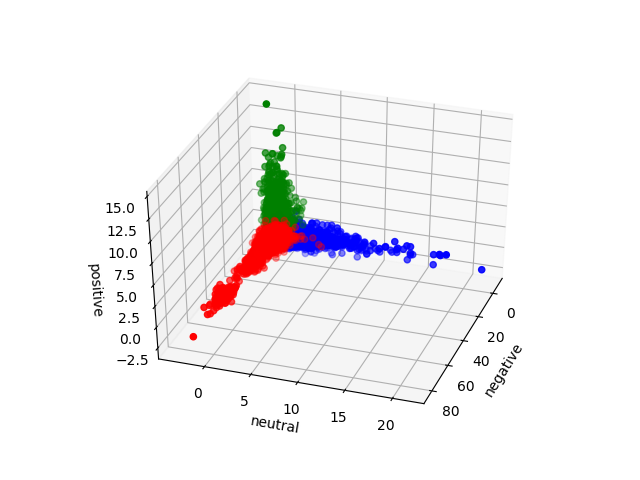

In [179]:
%matplotlib notebook
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

colors = ['red','blue','green']

fig = plt.figure()
ax= fig.gca(projection='3d')
ax.scatter3D(neg['negative'],neg['neutral'],neg['positive'],color=colors[0])
ax.scatter3D(neu['negative'],neu['neutral'],neu['positive'],color=colors[1])
ax.scatter3D(pos['negative'],pos['neutral'],pos['positive'],color=colors[2])
ax.set_xlabel('negative')
ax.set_ylabel('neutral')
ax.set_zlabel('positive')
ax.can_pan = True
ax.can_zoom = True
plt.show()

Looks like a knn or svm would be general and accurate

# Cross Validation

In [184]:
y = pd.DataFrame(t.y_train)
features = train['text']
y = y.as_matrix().astype(np.float).ravel()
features = features.as_matrix().astype(np.str)

In [185]:
from sklearn import model_selection
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
Classifiers = [
    tweet_clf(1,True),
    tweet_clf(2,True),
    tweet_clf(1,False),
    tweet_clf(2,False),
    ]

cv = model_selection.KFold(n_splits = 10 ,shuffle=True ,random_state=42)
cv.get_n_splits(features)

for clf in Classifiers:
    yhat = np.zeros(len(features))
    for train_idx, test_idx in cv.split(features):
        X_train = features[train_idx]
        y_train = y[train_idx]
        X_test,y_test = features[test_idx],y[test_idx]
        clf.fit(X_train,y_train)
        yhat[test_idx] = clf.predict(X_test)

    accuracy = accuracy_score(yhat, y)
    print('Accuracy of ', clf.__class__.__name__ , ' is ', accuracy)

C:\Users\alexf\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


Accuracy of  tweet_clf  is  0.777891621129
Accuracy of  tweet_clf  is  0.782445355191
Accuracy of  tweet_clf  is  0.779485428051
Accuracy of  tweet_clf  is  0.789617486339


## Test predictions

In [188]:
t = tweet_clf(2,False)
t.fit(train['text'],train['airline_sentiment'])
yhat = t.predict(test['text'])

result = pd.DataFrame()
result['Id'] = test['Id']
result['Prediction'] = ['negative' if x == 0 else 'neutral' if x == 1 else 'positive' for x in yhat]

result.to_csv(path_or_buf='./files/result_0005.csv', columns=['Id','Prediction'], index=False)